In [1]:
# Import the relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objects as go
from ipywidgets import interact, widgets

In [2]:
def sample_experiments(df, n_samples):
    """
    Randomly sample n_samples rows for each unique experiment in the dataset.
    
    Args:
    df (pd.DataFrame): The original dataset
    n_samples (int): Number of samples to take from each experiment
    
    Returns:
    pd.DataFrame: A new dataframe with n_samples rows for each experiment
    """
    # Group the dataframe by experiment
    grouped = df.groupby('Experiment')
    
    # Function to sample n rows or return all if less than n
    def sample_n_or_all(group):
        n = min(len(group), n_samples)
        return group.sample(n)
    
    # Apply the sampling function to each group and combine results
    sampled = grouped.apply(sample_n_or_all).reset_index(drop=True)
    
    return sampled


In [3]:
def extract_features(top_features_str):
    """Extract feature names from the Top Features string."""
    features = [f.split(':')[0].strip() for f in top_features_str.split(',')]
    return features

def process_dataset(df):
    # Extract features and create a new column
    df['Extracted_Features'] = df['Top Features'].apply(extract_features)
    
    # Create the first dataset: Feature counts
    feature_counts = []
    for (experiment, model, sample_size), group in df.groupby(['Experiment', 'Model', 'Sample Size']):
        all_features = [feature for features in group['Extracted_Features'] for feature in features]
        feature_count = Counter(all_features)
        for feature, count in feature_count.items():
            feature_counts.append({
                'Experiment': experiment,
                'Model': model,
                'Sample Size': sample_size,
                'Feature': feature,
                'Count': count
            })
    
    feature_counts_df = pd.DataFrame(feature_counts)
    
    # Create the second dataset: Average SHAP Match Percentage
    shap_avg = df.groupby(['Experiment', 'Model', 'Sample Size'])['SHAP Match %'].mean().reset_index()
    shap_avg = shap_avg.rename(columns={'SHAP Match %': 'Average SHAP Match %'})
    
    return feature_counts_df, shap_avg


In [4]:
# Load the experiment Data
experiment_dataset = pd.read_csv('Experiment_1_data.csv')

In [5]:
experiment_dataset.head()

,Experiment,Model,Sample Size,SHAP Match %,Top Features
0,Auto Premium,Random Forest,100,80.0,"Age: 203.4646, Annual kilometers: 93.0924, Bus..."
1,Auto Premium,XGBoost,100,80.0,"Annual kilometers: 175.5684, Age: 164.9741, Bu..."
2,Auto Premium,Gradient Boosting,100,80.0,"Age: 173.7618, Annual kilometers: 164.0942, Bu..."
3,Auto Premium,CatBoost,100,80.0,"Annual kilometers: 136.8489, Age: 125.1775, Bu..."
4,Auto Premium,ElasticNet,100,60.0,"Age: 187.1342, Business Use: 71.5217, Annual k..."


In [6]:
experiment_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16557 entries, 0 to 16556
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Experiment    16557 non-null  object 
 1   Model         16557 non-null  object 
 2   Sample Size   16557 non-null  int64  
 3   SHAP Match %  16557 non-null  float64
 4   Top Features  16557 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 646.9+ KB


In [7]:
# Count the number of rows for each unique value in the "Experiment" column
experiment_counts = experiment_dataset['Experiment'].value_counts().reset_index()
experiment_counts.columns = ['Experiment', 'Count']

# Display the result
print(experiment_counts)

              Experiment  Count
0           Auto Premium   5526
1  Environment Liability   5525
2         Cyber Security   5506


In [8]:
# Take a random number of columns for each experiment (3000)

experiment_dataset = sample_experiments(experiment_dataset, 5000)

In [16]:
# Count the number of rows for each unique value in the "Experiment" column
experiment_counts = experiment_dataset['Experiment'].value_counts().reset_index()
experiment_counts.columns = ['Experiment', 'Count']

# Display the result
experiment_counts


,Experiment,Count
0,Auto Premium,5000
1,Cyber Security,5000
2,Environment Liability,5000


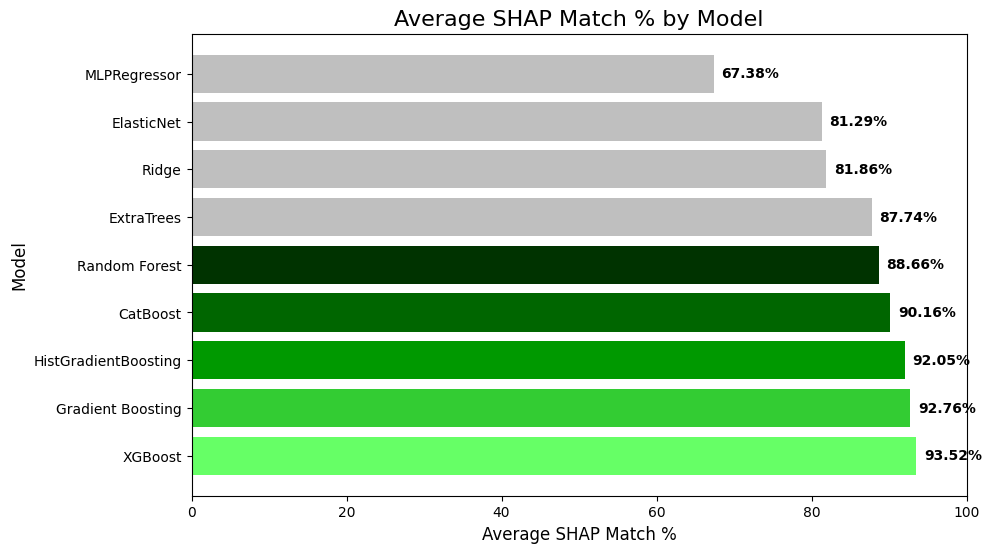

In [11]:
# Calculate average SHAP Match % for each model
model_avg_shap = experiment_dataset.groupby('Model')['SHAP Match %'].mean().sort_values(ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))

# Define custom colors: Shades of green for top 4 and gray shades for the rest
top_5_colors = ['#66FF66', '#33CC33', '#009900', '#006600', '#003300']
remaining_color = '#BFBFBF'  # Grey for the rest
colors = [top_5_colors[i] if i < 5 else remaining_color for i in range(len(model_avg_shap))]

bars = plt.barh(model_avg_shap.index, model_avg_shap.values, color=colors)
plt.title('Average SHAP Match % by Model', fontsize=16)
plt.xlabel('Average SHAP Match %', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 100)

# Add percentage labels on the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', 
             ha='left', va='center', fontweight='bold')




In [12]:

# Process the dataset
feature_counts, shap_avg = process_dataset(experiment_dataset)

/var/folders/ch/cnzx1kvd1d9_f94xydxjcr3m0000gq/T/ipykernel_44628/2836712614.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


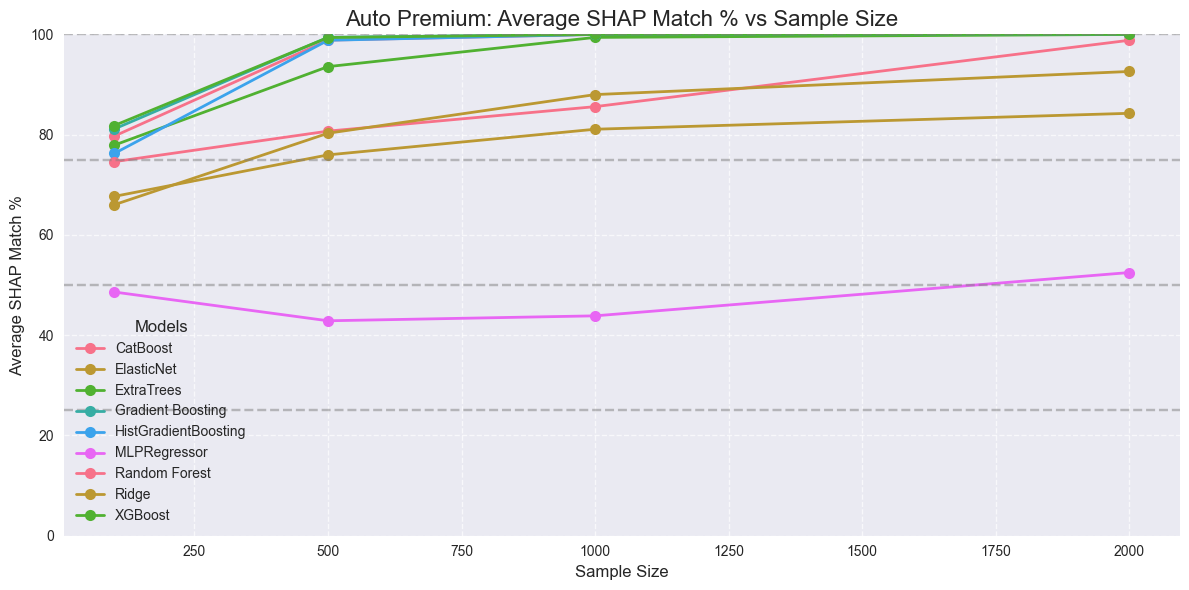

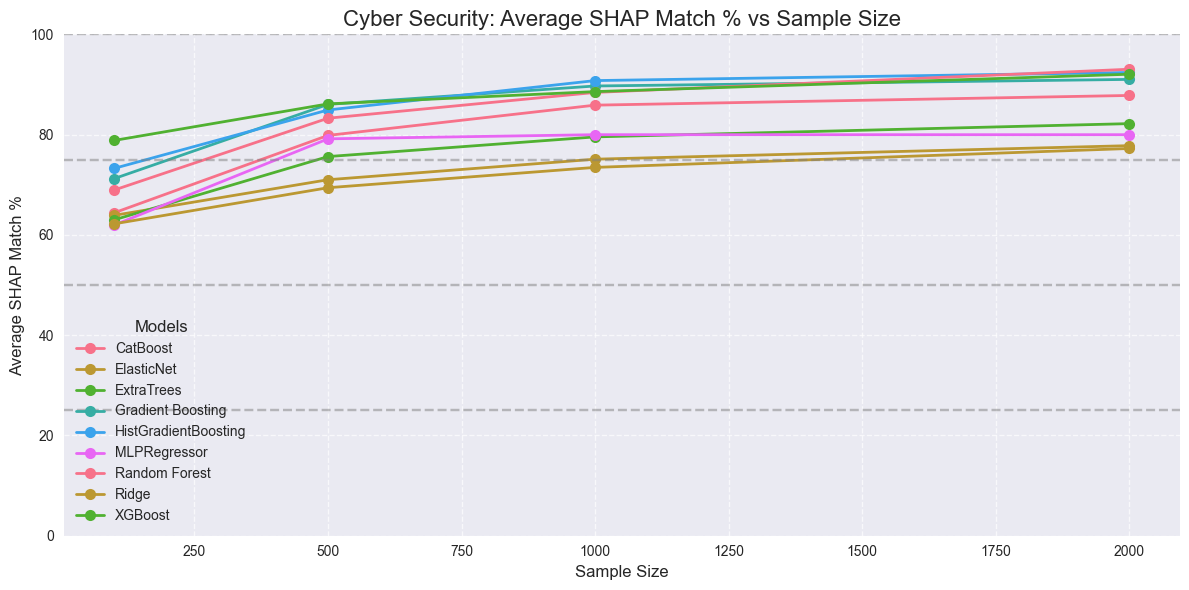

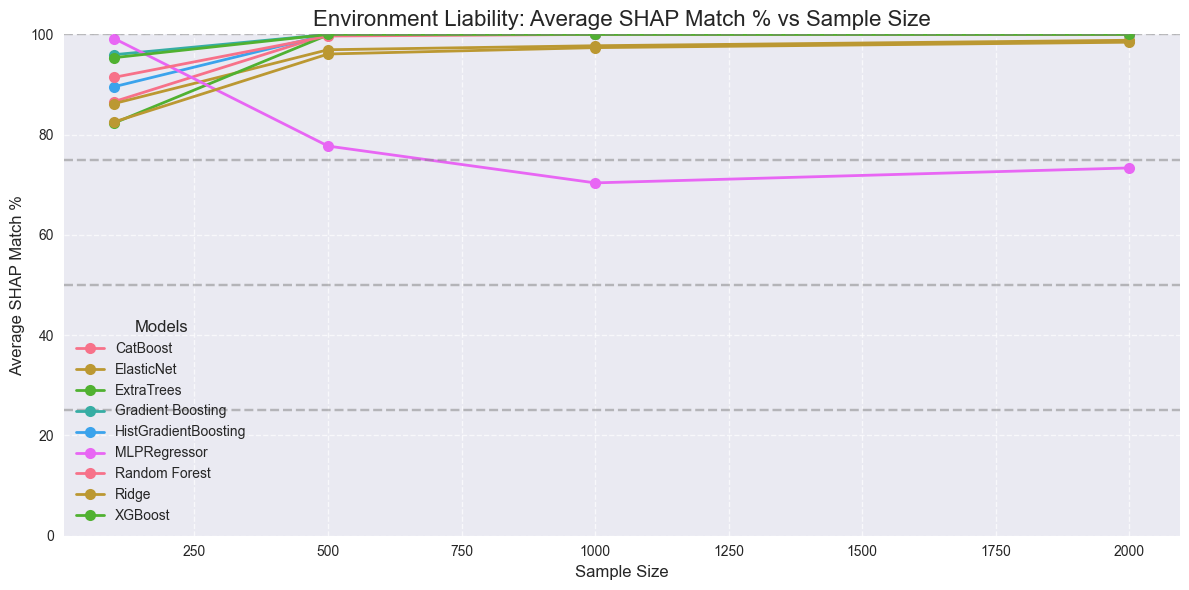

Diagrams have been created and saved.


In [13]:
# Set up the plot style
plt.style.use('seaborn')
sns.set_palette("husl")

# Function to create a diagram for each experiment
def create_diagram(experiment):
    # Filter data for the current experiment
    exp_data = shap_avg[shap_avg['Experiment'] == experiment]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot a line for each model
    for model in exp_data['Model'].unique():
        model_data = exp_data[exp_data['Model'] == model]
        plt.plot(model_data['Sample Size'], model_data['Average SHAP Match %'], 
                 marker='o', linewidth=2, markersize=8, label=model)
    
    # Customize the plot
    plt.title(f'{experiment}: Average SHAP Match % vs Sample Size', fontsize=16)
    plt.xlabel('Sample Size', fontsize=12)
    plt.ylabel('Average SHAP Match %', fontsize=12)
    plt.legend(title='Models', title_fontsize='12', fontsize='10')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis to start from 0 and end at 100
    plt.ylim(0, 100)
    
    # Add horizontal lines at 25% intervals
    for y in range(25, 101, 25):
        plt.axhline(y=y, color='gray', linestyle='--', alpha=0.5)
    
    # Save the plot
    plt.tight_layout()
    #plt.savefig(f'{experiment.replace(" ", "_")}_SHAP_Match.png', dpi=300)
    plt.show()
    plt.close()

# Create a diagram for each unique experiment
for experiment in shap_avg['Experiment'].unique():
    create_diagram(experiment)

print("Diagrams have been created and saved.")

In [14]:
# Create dropdown options
experiments = ['All'] + sorted(feature_counts['Experiment'].unique().tolist())
models = ['All'] + sorted(feature_counts['Model'].unique().tolist())
sample_sizes = ['All'] + sorted(feature_counts['Sample Size'].unique().tolist())

def create_plot(experiment, model, sample_size):
    # Filter data based on selections
    filtered_df = feature_counts.copy()
    if experiment != 'All':
        filtered_df = filtered_df[filtered_df['Experiment'] == experiment]
    if model != 'All':
        filtered_df = filtered_df[filtered_df['Model'] == model]
    if sample_size != 'All':
        filtered_df = filtered_df[filtered_df['Sample Size'] == sample_size]
    
    # Group by relevant columns and sum the Count
    if experiment == 'All':
        grouped = filtered_df.groupby(['Experiment', 'Feature'])['Count'].sum().reset_index()
        x_axis = 'Experiment'
        color = 'Feature'
        title = f'Feature Counts for All Experiments'
    elif model == 'All':
        grouped = filtered_df.groupby(['Model', 'Feature'])['Count'].sum().reset_index()
        x_axis = 'Model'
        color = 'Feature'
        title = f'Feature Counts for {experiment}'
    elif sample_size == 'All':
        grouped = filtered_df.groupby(['Sample Size', 'Feature'])['Count'].sum().reset_index()
        x_axis = 'Sample Size'
        color = 'Feature'
        title = f'Feature Counts for {experiment}, {model}'
    else:
        grouped = filtered_df
        x_axis = 'Feature'
        color = None
        title = f'Feature Counts for {experiment}, {model}, Sample Size {sample_size}'
    
    # Create the plot
    fig = go.Figure()
    
    if color:
        for feature in grouped['Feature'].unique():
            feature_data = grouped[grouped['Feature'] == feature]
            fig.add_trace(go.Bar(
                x=feature_data[x_axis],
                y=feature_data['Count'],
                name=feature
            ))
        fig.update_layout(barmode='group')
    else:
        fig.add_trace(go.Bar(
            x=grouped['Feature'],
            y=grouped['Count']
        ))
    
    fig.update_layout(
        title=title,
        xaxis_title=x_axis,
        yaxis_title='Count',
        legend_title='Feature'
    )
    
    fig.show()

# Create interactive widget
interact(
    create_plot,
    experiment=widgets.Dropdown(options=experiments, value='All', description='Experiment:'),
    model=widgets.Dropdown(options=models, value='All', description='Model:'),
    sample_size=widgets.Dropdown(options=sample_sizes, value='All', description='Sample Size:')
)

interactive(children=(Dropdown(description='Experiment:', options=('All', 'Auto Premium', 'Cyber Security', 'E…

<function __main__.create_plot(experiment, model, sample_size)>

In [15]:
# Create dropdown options
experiments = sorted(feature_counts['Experiment'].unique().tolist())
models = sorted(feature_counts['Model'].unique().tolist())

def create_plot(experiment, model):
    # Filter data based on selections
    filtered_df = feature_counts[(feature_counts['Experiment'] == experiment) & (feature_counts['Model'] == model)]
    
    # Create the plot
    fig = go.Figure()
    
    # Add a line for each feature
    for feature in filtered_df['Feature'].unique():
        feature_data = filtered_df[filtered_df['Feature'] == feature].sort_values('Sample Size')
        fig.add_trace(go.Scatter(
            x=feature_data['Sample Size'],
            y=feature_data['Count'],
            mode='lines+markers',
            name=feature
        ))
    
    # Update layout
    fig.update_layout(
        title=f'Feature Count Progression for {experiment}, {model}',
        xaxis_title='Sample Size',
        yaxis_title='Count',
        legend_title='Feature',
        hovermode='x unified'
    )
    
    # Update x-axis to show all sample sizes
    fig.update_xaxes(
        tickmode='array',
        tickvals=sorted(filtered_df['Sample Size'].unique())
    )
    
    fig.show()

# Create interactive widget
interact(
    create_plot,
    experiment=widgets.Dropdown(options=experiments, value=experiments[0], description='Experiment:'),
    model=widgets.Dropdown(options=models, value=models[0], description='Model:')
)

interactive(children=(Dropdown(description='Experiment:', options=('Auto Premium', 'Cyber Security', 'Environm…

<function __main__.create_plot(experiment, model)>